#<u>Introduction</u>

In this notebook, we will setup an enviroment to learn how to deal with large quantities of data, during a datathon. The general objective of this datathon is to put our Data Science and Spark skills into practice through a data driven challenge. The focus is on how the Spark platform is used and the benefits it provides for addressing the data processing tasks of the Big Data pipeline.

This project uses a IPYNB files which is a Jupyter Notebook, as format. The IPython Notebook is an interactive computational environment, in which you can combine code execution, rich text, mathematics, plots and rich media. Because it's open source, easy to use and quite well designed, Jypeter Notebook became one of the most used API by Data Scientists. 

The <a href="https://docs.google.com/document/d/1Kfmc21JBfWYwWTiiqvKm1VSO9thBf5YL/edit#heading=h.5kwb95rcbofb"> description</a> and the <a href="https://docs.google.com/document/d/1YR9Kuu7l0zI2STOzGivhGC4WydheVdAL/edit">objectives</a> give ressources and a few advice but the main point of this exercice is to discover how to work with big databases and experimente on a given subject. However, because we work on local machine with only one working CPU, we can't analyze big quantities of ressources with this setup. So we uses only small portion of the ressources files to work with.

Following this introduction is all the code to run the project, starting with its configuration.

In this report, the main goal is to gather data about specific aspects of a webpage, including its links in URL, how many page are available depending of the language, the number of bytes provided by a host or the IP of the contributors.

#Initialisation of the project

## Config

Install [Apache Spark](https://spark.apache.org) and the [Archive Unleashed Toolkit](https://aut.docs.archivesunleashed.org/docs/home) (AUT).


In [ ]:
# Set to True if working in Amazon SageMaker
SAGEMAKER = False

In [ ]:
%%capture

import os

APPS_HOME      = os.getcwd() + "/apps"

SPARK_VERSION  = "3.0.0"
HADOOP_VERSION = "2.7"
AUT_VERSION    = "0.91.0"
JAVA_VERSION   = "11"

SPARK_HADOOP_VERSION = "spark-{}-bin-hadoop{}".format(SPARK_VERSION, HADOOP_VERSION)

if SAGEMAKER:
    !sudo amazon-linux-extras install java-openjdk11 -y
    os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-11-openjdk-11.0.16.0.8-1.amzn2.0.1.x86_64"
else:
    !apt-get install openjdk-"$JAVA_VERSION"-jdk-headless
    os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-{}-openjdk-amd64".format(JAVA_VERSION)

!pip install -q findspark

!wget https://archive.apache.org/dist/spark/spark-"$SPARK_VERSION"/"$SPARK_HADOOP_VERSION".tgz
!wget https://github.com/archivesunleashed/aut/releases/download/aut-"$AUT_VERSION"/aut-"$AUT_VERSION".zip
!wget https://github.com/archivesunleashed/aut/releases/download/aut-"$AUT_VERSION"/aut-"$AUT_VERSION"-fatjar.jar

!tar -xf "$SPARK_HADOOP_VERSION".tgz
!mkdir -p "$APPS_HOME"
!mv spark-* aut-* "$APPS_HOME"

!rm -rf sample_data "$APPS_HOME"/"$SPARK_HADOOP_VERSION".tgz


## Spark init

Initialize spark in [single-node cluster](https://docs.databricks.com/clusters/single-node.html) and configure pyspark with the AUT toolkit.

In [ ]:
import os
import findspark

SPARK_DRIVER_MEMORY   = "8g"

os.environ["SPARK_HOME"] = "{}/{}".format(APPS_HOME, SPARK_HADOOP_VERSION)   
os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-memory {0} --jars {2}/aut-{1}-fatjar.jar --py-files {2}/aut-{1}.zip pyspark-shell'.format(SPARK_DRIVER_MEMORY, AUT_VERSION, APPS_HOME)

findspark.init()

In [ ]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc, col, udf
from pyspark.sql.types import StringType

sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

sc

<SparkContext master=local[*] appName=pyspark-shell>

## Creating Web Archives

Example of [web archiving using WGET](https://wiki.archiveteam.org/index.php/Wget_with_WARC_output) as web crawler.

In [ ]:
%%writefile input.txt
http://www.espinosa-oviedo.com
http://www.vargas-solar.com

Writing input.txt


In [ ]:
LEVEL=1       # maximum number of links to follow (i.e, crawl depth)
WAIT=0.1      # num. seconds to wait between consecutive calls 

IN_FILE       = "input.txt"  # list of URLs to crawl
OUT_DIR       = "WARC"       # folder where crawl results will be stored
OUT_WARC_FILE = "out"        # prefix for WARC files
OUT_LOG_FILE  = "log.txt"    # file containing WGET log

# https://www.gnu.org/software/wget/manual/wget.html
!wget \
  --delete-after -nd \
  --input-file={IN_FILE}  \
  --level={LEVEL}    \
  --no-parent        \
  --wait={WAIT}      \
  --random-wait      \
  --adjust-extension \
  --reject=css,js,xml,rss,php  \
  --user-agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Safari/605.1.15" \
  --warc-file=out  \
  --warc-max-size=300m  \
  --no-warc-keep-log  \
  --output-file={OUT_LOG_FILE}


In [ ]:
# Move resulting files to the OUT_DIR folder
!mkdir -p {OUT_DIR} 
!mv *.warc*  *.txt  {OUT_DIR}

## Collecting LIFRANUM Web Archives

LIFRANUM's WARC files are stored in google drive. Uncomment the lines below to retrieve any of the dataset.

In [ ]:
%%capture 
!pip install -q gdown

#!gdown https://drive.google.com/drive/folders/1xqDsY5KOeK5OMhW39EH37l79Pn-v59B_?usp=sharing -O ./LIFRANUM/autre --folder
#!gdown https://drive.google.com/drive/folders/170j3r23YJBlOpGsKrcZRSs3bqrS03qhi?usp=sharing -O ./LIFRANUM/cartoweb --folder
!gdown https://drive.google.com/drive/folders/1NLuWLOldfmpwPeAr9Th_HCeH6ZoSw0zr?usp=sharing -O ./LIFRANUM/lifranum-method --folder
#!gdown https://drive.google.com/drive/folders/1wehg3nnCks9iVIvuXMZ5u685ocq__dQe?usp=sharing -O ./LIFRANUM/repo-ecritures-num --folder

## Querying Web Archives

Note: 

* **AUT generates dataframes**. See the [AUT dataframe schemas](https://aut.docs.archivesunleashed.org/docs/dataframe-schemas) and the [Spark SQL guide](https://spark.apache.org/docs/3.0.0/sql-getting-started.html) for more info.
* More examples are available in the [AUT documentation](https://aut.docs.archivesunleashed.org/docs/home). 



In [ ]:
from aut import *

WARCs_path = "/content/LIFRANUM/lifranum-method/out-00000.warc.gz"

# <u> DATATHON </u>

## Extract webpages URLs 

Spark Dataframe API

In [ ]:
WebArchive(sc, sqlContext, WARCs_path) \
  .webpages() \
  .select("url") \
  .show(20, False)  

+--------------------------------------------------------------------------------------+
|url                                                                                   |
+--------------------------------------------------------------------------------------+
|http://murielecamac.blogspot.com/                                                     |
|http://murielecamac.blogspot.com/p/publications.html                                  |
|http://murielecamac.blogspot.com/2022/04/nouveau-recueil-une-femme-cest-un-indien.html|
|https://murielecamac.blogspot.com/2019/04/nouvelle-parution-muriele-camac-en.html     |
|http://murielecamac.blogspot.com/2022/                                                |
|http://murielecamac.blogspot.com/2022/04/                                             |
|http://murielecamac.blogspot.com/2020/                                                |
|http://murielecamac.blogspot.com/2020/11/                                             |
|http://murielecamac.

Spark SQL equivalent

In [ ]:
df = WebArchive(sc, sqlContext, WARCs_path).webpages()
df.createOrReplaceTempView("webpages")

sql='''
    SELECT url 
    FROM webpages 
'''

sqlContext.sql(sql).show(20, False)

+--------------------------------------------------------------------------------------+
|url                                                                                   |
+--------------------------------------------------------------------------------------+
|http://murielecamac.blogspot.com/                                                     |
|http://murielecamac.blogspot.com/p/publications.html                                  |
|http://murielecamac.blogspot.com/2022/04/nouveau-recueil-une-femme-cest-un-indien.html|
|https://murielecamac.blogspot.com/2019/04/nouvelle-parution-muriele-camac-en.html     |
|http://murielecamac.blogspot.com/2022/                                                |
|http://murielecamac.blogspot.com/2022/04/                                             |
|http://murielecamac.blogspot.com/2020/                                                |
|http://murielecamac.blogspot.com/2020/11/                                             |
|http://murielecamac.

In [ ]:
df.show()

+--------------+--------------------+--------------------+--------------+--------+--------------------+
|    crawl_date|                 url|mime_type_web_server|mime_type_tika|language|             content|
+--------------+--------------------+--------------------+--------------+--------+--------------------+
|20221009201110|http://murielecam...|           text/html|     text/html|      fr|HTTP/1.1 200 OK
...|
|20221009201119|http://murielecam...|           text/html|     text/html|      fr|HTTP/1.1 200 OK
...|
|20221009201122|http://murielecam...|           text/html|     text/html|      fr|HTTP/1.1 200 OK
...|
|20221009201128|https://murieleca...|           text/html|     text/html|      fr|HTTP/1.1 200 OK
...|
|20221009201129|http://murielecam...|           text/html|     text/html|      fr|HTTP/1.1 200 OK
...|
|20221009201131|http://murielecam...|           text/html|     text/html|      fr|HTTP/1.1 200 OK
...|
|20221009201133|http://murielecam...|           text/html|     text/ht

In [ ]:
%%capture
!pip install tldextract
from urllib.parse import urlparse
import tldextract 
@udf("string")
def extract_hostname(s):
    return urlparse(s).hostname
@udf("string")
def extract_url_domain(s):
  return tldextract.extract(s).domain
@udf("string")
def extract_url_subdomain(s):
  return tldextract.extract(s).subdomain
@udf("string")
def extract_url_tld(s):
  return tldextract.extract(s).suffix
@udf("string")
def extract_url_registered_domain(s):
  return tldextract.extract(s).registered_domain
@udf("string")
def extract_url_domain_reversed(s):
  text=urlparse(s).hostname
  t=text.split('.')
  t.reverse()
  text='.'.join(t)
  return text
@udf("string")
def extract_port(s):
  return str(urlparse(s).port)
@udf("string")
def extract_requete(s):
  return urlparse(s).scheme
@udf("string")
def extract_lenth(s):
  return urlparse(s).scheme
df2=WebArchive(sc, sqlContext, WARCs_path).webpages()\
.withColumn("hostname", extract_hostname("url") )\
  .withColumn("url_domain", extract_url_domain("url"))\
  .withColumn("url_subdomain", extract_url_subdomain("url"))\
  .withColumn("url_tld", extract_url_tld("url"))\
  .withColumn("url_domain_reversed", extract_url_domain_reversed("url"))\
  .withColumn("url_registered_domain", extract_url_registered_domain("url"))\
  .withColumn("port", extract_port("url"))\
  .withColumn("requete", extract_requete("url")).withColumn("content_length", extract_requete("url"))
df2.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df3=df2.drop("content")
df3.show()

+--------------+--------------------+--------------------+--------------+--------+--------------------+----------+-------------+-------+--------------------+---------------------+----+-------+--------------+
|    crawl_date|                 url|mime_type_web_server|mime_type_tika|language|            hostname|url_domain|url_subdomain|url_tld| url_domain_reversed|url_registered_domain|port|requete|content_length|
+--------------+--------------------+--------------------+--------------+--------+--------------------+----------+-------------+-------+--------------------+---------------------+----+-------+--------------+
|20221009201110|http://murielecam...|           text/html|     text/html|      fr|murielecamac.blog...|  blogspot| murielecamac|    com|com.blogspot.muri...|         blogspot.com|None|   http|          http|
|20221009201119|http://murielecam...|           text/html|     text/html|      fr|murielecamac.blog...|  blogspot| murielecamac|    com|com.blogspot.muri...|         bl

## Number of pages per language provided by the hosts reported in the studied data collection 

In [ ]:
df3\
  .select("language") \
  .groupBy("language") \
  .count() \
  .sort(desc("count"))\
  .show(10, False)

+--------+-----+
|language|count|
+--------+-----+
|fr      |6532 |
|en      |29   |
|br      |9    |
|es      |6    |
|de      |4    |
|ht      |2    |
|oc      |1    |
|hu      |1    |
|af      |1    |
|ca      |1    |
+--------+-----+
only showing top 10 rows



In [ ]:
domains=df3\
  .select("hostname") \
  .groupBy("hostname") \
  .count() \
  .sort(desc("count"))\


In [ ]:
domains.count()

101

## Total number of bytes provided by each host

In [ ]:
df4=df2.select("content")


In [ ]:
df4_panda=df4.toPandas()

In [ ]:
df4_panda.shape

(6590, 1)

In [ ]:
c=0
j=0
k=0
for i in range(6590):
  string=df4_panda.iloc[i,0]
  c=c+('amour' in string)
  j=j+('haine' in string)
  k=k+(('amour' in string) and ('haine' in string))
print(c)
print(j)
print(k)

3857
1298
889


The data is insufficient to answer the question, as we only have eight pages including the meta data content-lenght over a thousand pages.

##IPs of the hosts contributing with Web pages in the collection.

In [ ]:
import re
f = open("/content/LIFRANUM/lifranum-method/log.txt", "r")
pattern = re.compile(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})')

lst=[]

for line in f:
  if "Connecting to" in line[:len("Connecting to")]:
    if(pattern.search(line)!=None):

      
      text=line.split(" ")
      website=text[2]
      lst.append([website,pattern.search(line)[0]])
lst2=[]
for i in lst:
  if i not in lst2:
    lst2.append(i)

print(lst2)
print(len(lst2))


[['575.tempslibres.org', '81.88.52.44'], ['adamante-images-et-reves.over-blog.com', '185.128.239.39'], ['afdj.over-blog.com', '185.128.239.39'], ['ahoui.eklablog.com', '212.83.152.79'], ['alain-cotten.over-blog.com', '185.128.239.66'], ['alainhaye.over-blog.com', '185.128.239.39'], ['allerauxessentiels.over-blog.com', '185.128.239.39'], ['almasoror.hautetfort.com', '178.32.100.231'], ['amtealty.e-monsite.com', '212.83.158.152'], ['ancrages.ca', '199.58.80.35'], ['andree-wizem-imagerie.eklablog.com', '212.83.152.79'], ['annscott.fr', '213.186.33.87'], ['anothine-l.blogg.org', '212.83.152.79'], ['anthosuballix.canalblog.com', '195.137.184.101'], ['ardentpays12.over-blog.com', '185.128.239.66'], ['arielle.eklablog.com', '212.83.152.79'], ['armand.le.poete.free.fr', '212.27.63.114'], ['association-francophone-haibun.com', '46.105.57.169'], ['atelierdechoupie.canalblog.com', '195.137.184.101'], ['auventdesmots.over-blog.com', '185.128.239.39'], ['bashotage.over-blog.com', '185.128.239.66'],

In [ ]:
import requests
def get_location(ip_address):
    response = requests.get(f'https://ipapi.co/{ip_address}/json/').json()
    location_data = {
        "ip": ip_address,
        "city": response.get("city"),
        "region": response.get("region"),
        "country": response.get("country_name")
    }
    return location_data
    

In [ ]:
urls=[]
ip=[]
villes=[]
pays=[]
for i in lst2:
  urls.append(i[0])
  ip.append(i[1])
  loc_data=get_location(i[1])
  villes.append(loc_data["city"])
  pays.append(loc_data["country"])

In [ ]:
import pandas as pd
d = {'url': urls, 'ip': ip,'ville':villes,'pays':pays}
df_ip=pd.DataFrame(data=d)
df_ip

,url,ip,ville,pays
0,575.tempslibres.org,81.88.52.44,Bergamo,Italy
1,adamante-images-et-reves.over-blog.com,185.128.239.39,Paris,France
2,afdj.over-blog.com,185.128.239.39,Paris,France
3,ahoui.eklablog.com,212.83.152.79,Paris,France
4,alain-cotten.over-blog.com,185.128.239.66,Paris,France
...,...,...,...,...
521,www.uneq.qc.ca,69.51.204.33,Lac-Etchemin,Canada
522,www.urbain-trop-urbain.fr,213.186.33.87,Saran,France
523,www.wattpad.com,18.161.111.22,Marseille,France
524,xavierfisselier.wordpress.com,192.0.78.12,None,None


In [ ]:
df_ip['pays'].isnull().sum()

221

In [ ]:
countriesData = df_ip['pays'].dropna()
citysData =df_ip["ville"].dropna()
countriesData

0              Italy
1             France
2             France
3             France
4             France
           ...      
520           France
521           Canada
522           France
523           France
525    United States
Name: pays, Length: 305, dtype: object

In [ ]:
countriesData.unique()

array(['Italy', 'France', 'Canada', 'United States', 'Switzerland',
       'Ireland', 'Netherlands', 'Germany', 'Luxembourg',
       'United Kingdom'], dtype=object)

In [ ]:
citysData

0               Bergamo
1                 Paris
2                 Paris
3                 Paris
4                 Paris
             ...       
520    Clermont-Ferrand
521        Lac-Etchemin
522               Saran
523           Marseille
525       San Francisco
Name: ville, Length: 305, dtype: object

In [ ]:
citysData.unique()

array(['Bergamo', 'Paris', 'Gravelines', 'Saint-Maur-des-Fossés',
       'Montreal', 'Saran', 'Levallois-Perret', 'Rouen', 'Saint-Ouen',
       'Nantes', 'Chatte', 'Ashburn', 'Marly-le-Roi', 'Roubaix',
       'Swarthmore', 'San Francisco', 'Bourg-les-Valence', 'Marseille',
       'Beauharnois', 'Issy-les-Moulineaux', 'Noisy-le-Grand', 'Burnaby',
       'Clermont-Ferrand', 'Houston', 'Burlington', 'Bolton-Est',
       'Shoreview', 'Lonay', 'Washington', 'Dublin', 'Seattle',
       'Amsterdam', 'Brea', 'Essen', 'Bissen', 'London', 'Clichy',
       'Saint-Jean-sur-Richelieu', 'La Grande-Motte', 'Toronto', 'Lille',
       'Clichy-sous-Bois', 'Golbey', 'Frankfurt am Main', 'Kansas City',
       'Lac-Etchemin'], dtype=object)

In [ ]:
!pip install -U iso3166


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from iso3166 import countries
print(countries.get('FRANCE'))


Country(name='France', alpha2='FR', alpha3='FRA', numeric='250', apolitical_name='France')


In [ ]:
import numpy as np
def rename(country):
    try:
        return countries.get(country).alpha3
    except:
        return (np.nan)
old_sample_number = countriesData.shape[0]
countriesData = countriesData.apply(rename)
countriesData = countriesData.dropna()

new_sample_number = countriesData.shape[0]
print('we lost', old_sample_number-new_sample_number, 'samples after converting')

we lost 68 samples after converting


In [ ]:
countriesData

0      ITA
1      FRA
2      FRA
3      FRA
4      FRA
      ... 
519    FRA
520    FRA
521    CAN
522    FRA
523    FRA
Name: pays, Length: 237, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


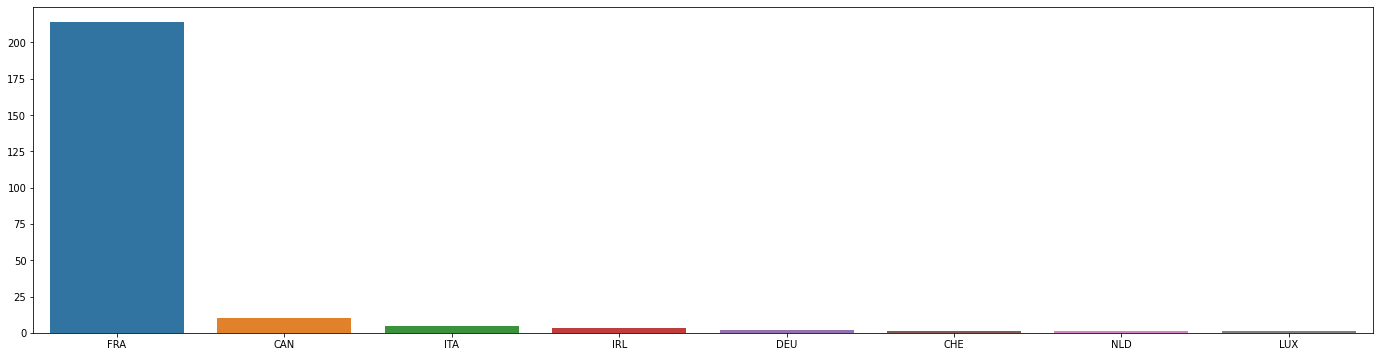

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(24, 6))
sns.barplot(countriesData.value_counts()[countriesData.value_counts()>0].index, countriesData.value_counts()[countriesData.value_counts()>0].values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


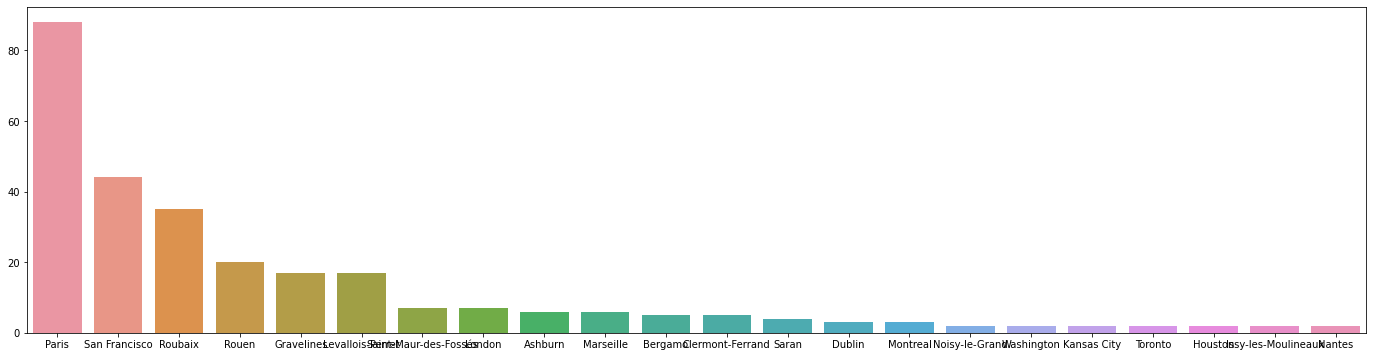

In [ ]:
plt.figure(figsize=(24, 6))
sns.barplot(citysData.value_counts()[citysData.value_counts()>1].index, citysData.value_counts()[citysData.value_counts()>1].values)

In [ ]:
country_df = pd.DataFrame(data=[countriesData.value_counts().index, countriesData.value_counts().values],index=['country','count']).T
country_df['count']=pd.to_numeric(country_df['count'])

In [ ]:
country_df.head()

,country,count
0,FRA,214
1,CAN,10
2,ITA,5
3,IRL,3
4,DEU,2


In [ ]:
import plotly.express as px
fig = px.scatter_geo(country_df, locations="country", size='count',
                     hover_name="country", color='country',
                     projection="natural earth")
fig.show()

In [ ]:
def get_lon_lat(ville):
    limit='1'
    key='07d7c7615f43be1e4b44b9d5d36788d0'
    response = requests.get(f'http://api.openweathermap.org/geo/1.0/direct?q={ville}&limit={limit}&appid={key}').json()
    location_data = {
        "lon": response[0].get('lon'),
        "lat": response[0].get("lat"),
        
    }
    return location_data

In [ ]:
city_df = pd.DataFrame(data=[citysData.value_counts().index, citysData.value_counts().values],index=['city','count']).T
city_df['count']=pd.to_numeric(city_df['count'])

In [ ]:
city_df

,city,count
0,Paris,88
1,San Francisco,44
2,Roubaix,35
3,Rouen,20
4,Gravelines,17
5,Levallois-Perret,17
6,Saint-Maur-des-Fossés,7
7,London,7
8,Ashburn,6
9,Marseille,6


In [ ]:
get_lon_lat('Paris')

{'lon': 2.3200410217200766, 'lat': 48.8588897}

In [ ]:
city_df["lon"]=city_df["city"].apply(lambda x: get_lon_lat(x)["lon"])
city_df["lat"]=city_df["city"].apply(lambda x: get_lon_lat(x)["lat"])

In [ ]:
city_df

,city,count,lon,lat
0,Paris,88,2.320041,48.858890
1,San Francisco,44,-122.419906,37.779026
2,Roubaix,35,3.174173,50.691589
3,Rouen,20,1.093966,49.440459
4,Gravelines,17,2.127312,50.987070
5,Levallois-Perret,17,2.288168,48.892956
6,Saint-Maur-des-Fossés,7,2.485301,48.803306
7,London,7,-0.127647,51.507322
8,Ashburn,6,-77.487490,39.043719
9,Marseille,6,5.369953,43.296174


In [ ]:
# import the library
import folium

# Make an empty map
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
data=city_df
for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['city'],
      radius=float(data.iloc[i]['count'])*800,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

In [ ]:
m

#CONCLUSION

Using some tools such as WebArchive or pandas, we were able to collect quite a lot of advanced informations about specific aspects of a webpage, including its links in URL, how many page are available depending of the language, the number of bytes provided by a host or the IP of the contributors.
We can see that french is by far the most used language, followed by english. So it makes sense that most of the contributor of those pages come from France, especially from Paris.